Vasmos a cargar el dataset de AirBnB descargado de [aquí](https://public.opendatasoft.com/explore/dataset/airbnb-listings/export/?disjunctive.host_verifications&disjunctive.amenities&disjunctive.features&q=Madrid&dataChart=eyJxdWVyaWVzIjpbeyJjaGFydHMiOlt7InR5cGUiOiJjb2x1bW4iLCJmdW5jIjoiQ09VTlQiLCJ5QXhpcyI6Imhvc3RfbGlzdGluZ3NfY291bnQiLCJzY2llbnRpZmljRGlzcGxheSI6dHJ1ZSwiY29sb3IiOiJyYW5nZS1jdXN0b20ifV0sInhBeGlzIjoiY2l0eSIsIm1heHBvaW50cyI6IiIsInRpbWVzY2FsZSI6IiIsInNvcnQiOiIiLCJzZXJpZXNCcmVha2Rvd24iOiJyb29tX3R5cGUiLCJjb25maWciOnsiZGF0YXNldCI6ImFpcmJuYi1saXN0aW5ncyIsIm9wdGlvbnMiOnsiZGlzanVuY3RpdmUuaG9zdF92ZXJpZmljYXRpb25zIjp0cnVlLCJkaXNqdW5jdGl2ZS5hbWVuaXRpZXMiOnRydWUsImRpc2p1bmN0aXZlLmZlYXR1cmVzIjp0cnVlfX19XSwidGltZXNjYWxlIjoiIiwiZGlzcGxheUxlZ2VuZCI6dHJ1ZSwiYWxpZ25Nb250aCI6dHJ1ZX0%3D&location=16,41.38377,2.15774&basemap=jawg.streets)

![](descargar.png)

In [1]:
airbnb<-read.csv('airbnb-listings.csv',sep = ';')
options(repr.plot.height=4,repr.plot.width=6,repr.plot.res = 300)

Vamos a quedarnos con las columnas de mayor interés:

'City','Room.Type','Neighbourhood','Accommodates','Bathrooms','Bedrooms','Beds','Price','Square.Feet','Guests.Included','Extra.People','Review.Scores.Rating','Latitude', 'Longitude'

In [2]:
columns <- c('City','Room.Type','Neighbourhood','Accommodates','Bathrooms','Bedrooms','Beds','Price',
  'Square.Feet','Guests.Included','Extra.People','Review.Scores.Rating','Latitude', 'Longitude')

airbnb <- airbnb[columns]

In [3]:
colnames(airbnb)

[1] "City"                 "Room.Type"            "Neighbourhood"       
 [4] "Accommodates"         "Bathrooms"            "Bedrooms"            
 [7] "Beds"                 "Price"                "Square.Feet"         
[10] "Guests.Included"      "Extra.People"         "Review.Scores.Rating"
[13] "Latitude"             "Longitude"

Nos quedarmos solo con las entradas de Madrid para Room.Type=="Entire home/apt" y cuyo barrio (Neighbourhood) no está vacio ''
Podemos eliminar las siguientes columnas que ya no son necesarias:
"Room.Type",'City'

Llama a nuevo dataframe df_madrid.

In [4]:
df_madrid <- subset(airbnb, City == 'Madrid')
df_madrid <- subset(df_madrid, Room.Type == 'Entire home/apt')
df_madrid <- subset(df_madrid, Neighbourhood != '')

toDelete <- c('Room.Type', 'City')
df_madrid <- df_madrid[ , !(names(df_madrid) %in% toDelete)]
#head(df_madrid)

¿Que porcentaje de los apartamentos no muestran los metros cuadrados? Es decir, ¿cuantos tienen NA en Square.Meters?

In [5]:
pieToMetro = 0.092903
df_madrid['Square.Meters'] = df_madrid['Square.Feet']*pieToMetro

In [6]:
print(paste("Hay:", sum(is.na(df_madrid['Square.Meters'])), "valores NA en la columna Square.Meters"))

[1] "Hay: 5254 valores NA en la columna Square.Meters"


In [7]:
toDelete <- c('Square.Feet')
df_madrid <- df_madrid[ , !(names(df_madrid) %in% toDelete)]

De todos los apartamentos que tienen un valor de metros cuadrados diferente de NA 
¿Que porcentaje de los apartamentos tienen 0 metros cuadrados?

In [8]:
table(as.factor(df_madrid$Square.Meters))['0']

0 
128

In [9]:
paste("El porcentaje de ceros es:", round((128/length(df_madrid$Square.Meters)*100),2), "%")

[1] "El porcentaje de ceros es: 2.29 %"

Reemplazar todos los 0m^2 por NA 

In [10]:
df_madrid$Square.Meters[df_madrid$Square.Meters==0] <- NA

Son muchos, vamos a intentar crear un modelo que nos prediga cuantos son los metros cuadrados en función del resto de variables para tratar de rellenar esos NA.

Antes de eso deberíamos pintar el histograma de los metros cuadrados y ver si tenemos que filtrar algún elemento más.

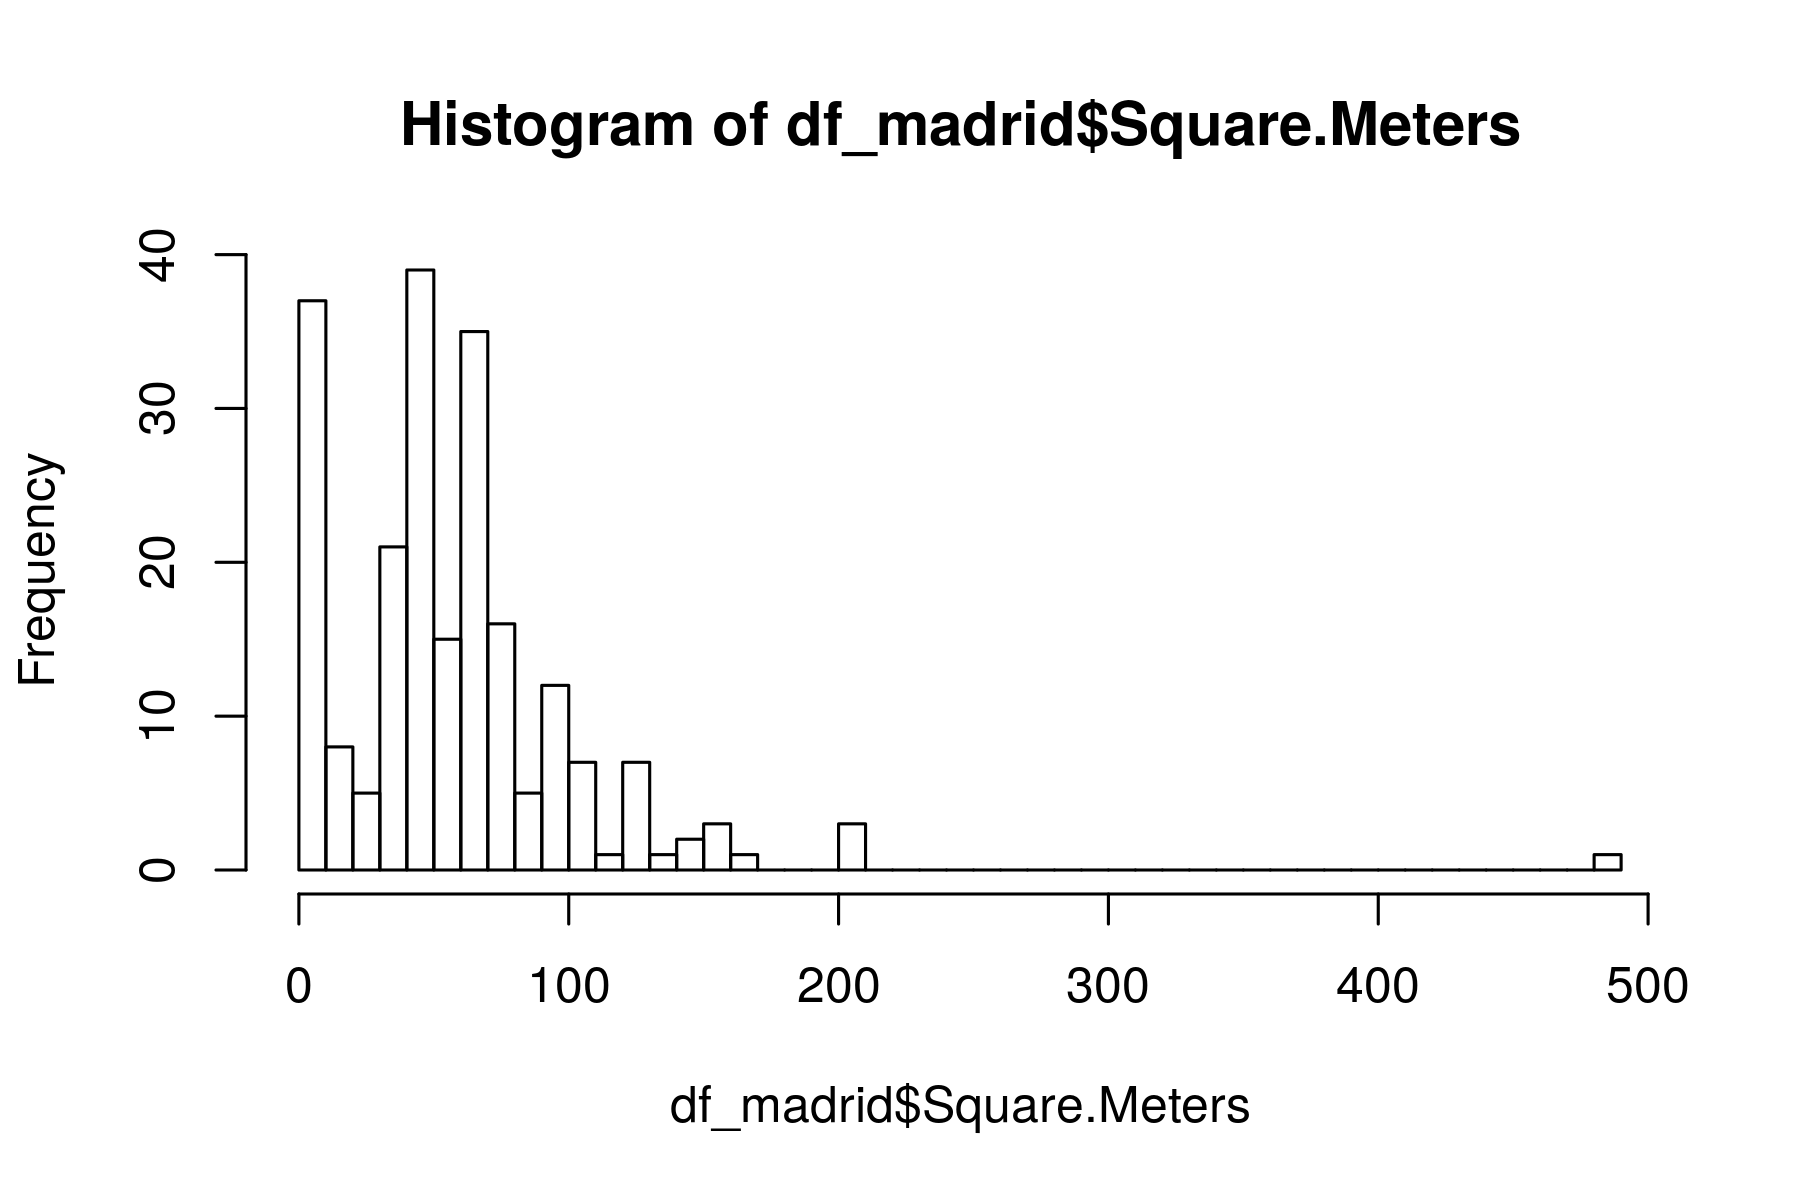

In [11]:
library(ggplot2)
hist(df_madrid$Square.Meters,40)

Asigna el valor NA a la columna Square.Meters de los apartamentos que tengan menos de 20 m^2

In [12]:
df_madrid$Square.Meters[df_madrid$Square.Meters<20] <- NA

El barrio parece ser un indicador importante para los metros cuadrados de un apartamento.

Vamos a agrupar los barrios por metros cuadrados. Podemos usar una matriz de similaridad de Tukey tal y como hicimos en el curso de estadística:

In [13]:
library(dplyr)

neighb_all_na <- df_madrid %>% group_by(Neighbourhood) %>% 
  summarise(num_na=sum(is.na(Square.Meters))/length(Square.Meters)) %>% filter(num_na==1) %>% select(Neighbourhood)
df_madrid <- df_madrid[!df_madrid$Neighbourhood %in% neighb_all_na$Neighbourhood,]


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [14]:
#str(df_madrid['Square.Meters'])
#sum(is.na(df_madrid['Square.Meters']))

df_madrid_no_na <- df_madrid[complete.cases(df_madrid), ]
str(df_madrid_no_na)



'data.frame':	165 obs. of  12 variables:
 $ Neighbourhood       : Factor w/ 391 levels "","Acacias","Acton",..: 169 217 57 217 109 179 179 317 81 81 ...
 $ Accommodates        : int  3 5 6 2 3 5 4 5 9 4 ...
 $ Bathrooms           : num  1 2.5 2 1 1 1 1 1 2 2 ...
 $ Bedrooms            : int  0 3 2 0 1 2 2 2 3 1 ...
 $ Beds                : int  1 3 4 1 2 3 1 5 8 1 ...
 $ Price               : int  53 73 85 75 85 90 100 100 100 46 ...
 $ Guests.Included     : int  1 2 4 1 2 2 2 2 4 2 ...
 $ Extra.People        : int  10 10 10 0 8 20 10 5 10 7 ...
 $ Review.Scores.Rating: int  90 96 100 67 93 88 92 91 90 93 ...
 $ Latitude            : num  40.4 40.4 40.5 40.4 40.4 ...
 $ Longitude           : num  -3.7 -3.71 -3.68 -3.7 -3.7 ...
 $ Square.Meters       : num  45 100 105 35 65 ...


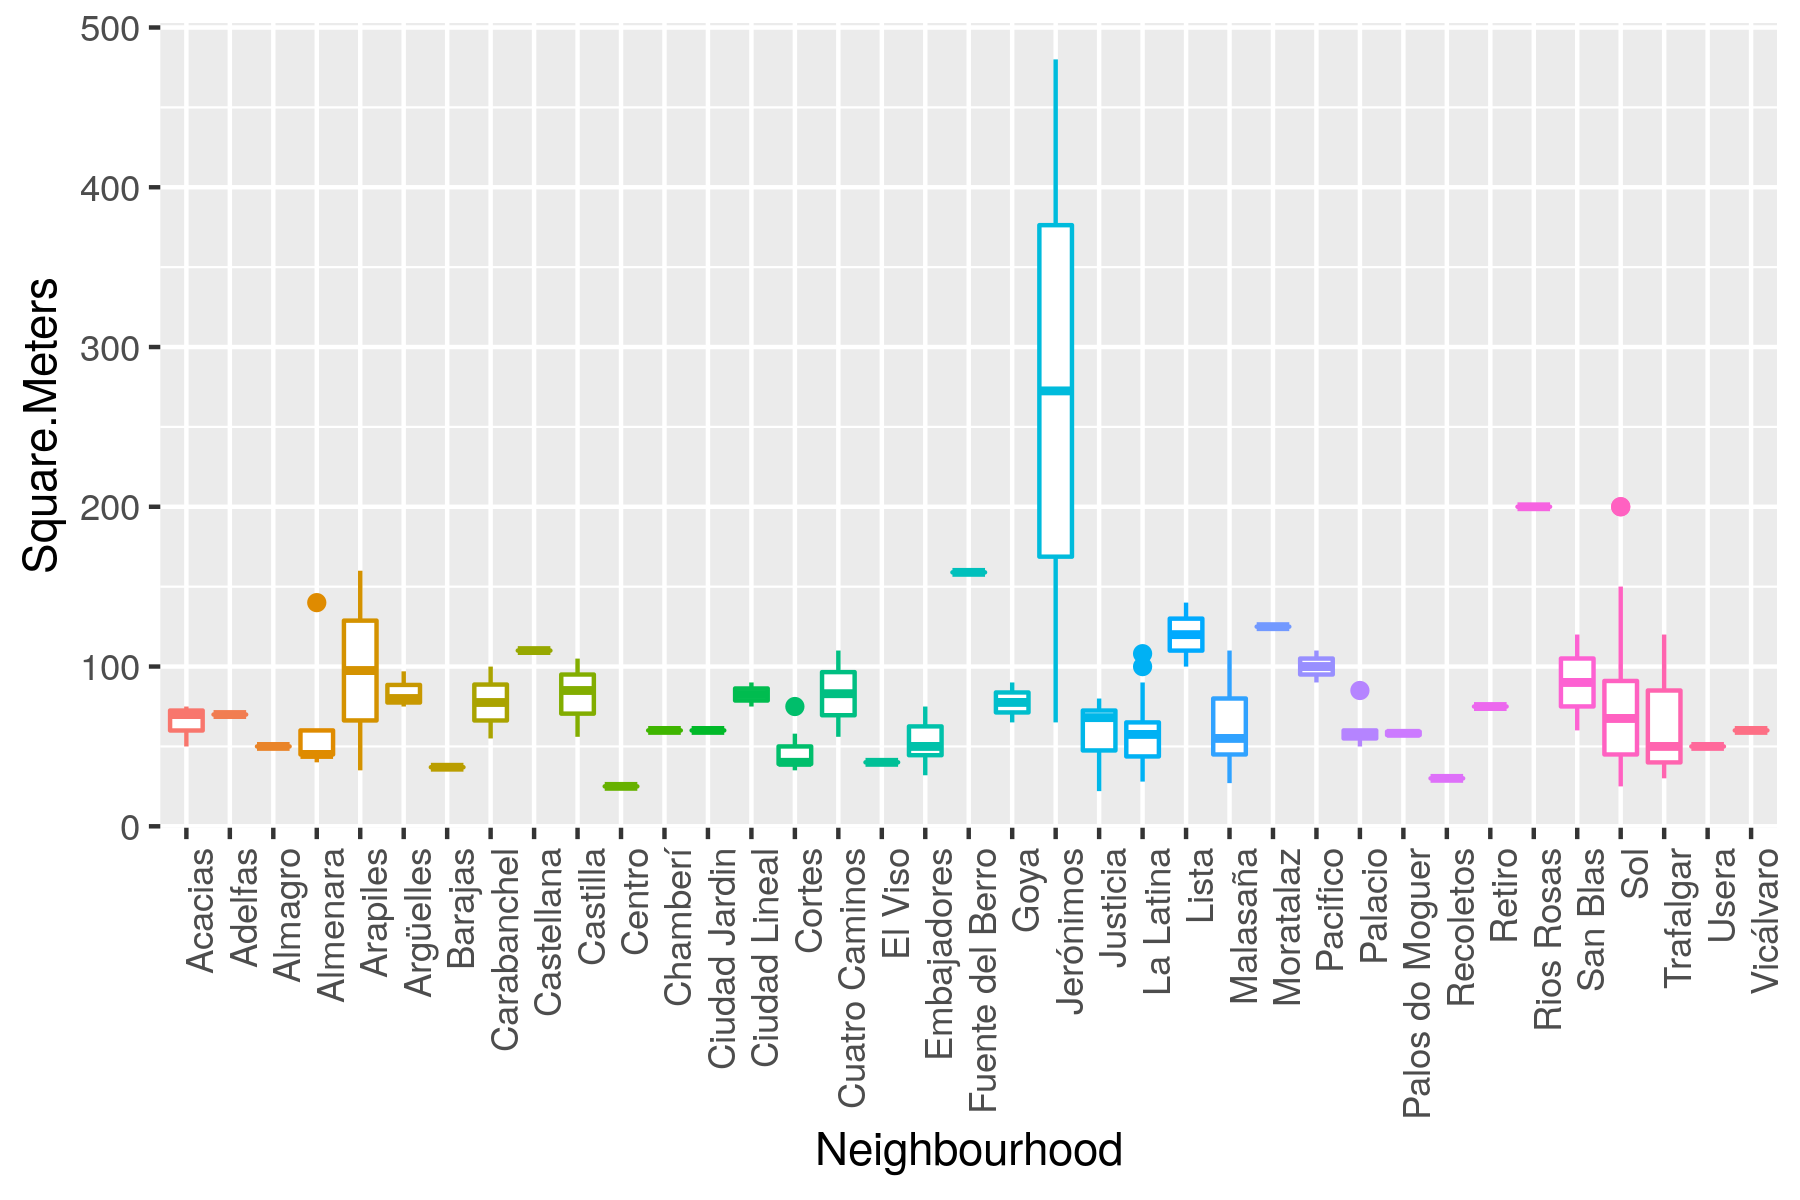

In [15]:
library(ggplot2)
ggplot(df_madrid_no_na, aes(y=Square.Meters, x=Neighbourhood, color=Neighbourhood))+geom_boxplot()+
theme(axis.text.x = element_text(angle = 90, hjust = 1),legend.position="none")

<font color = blue>
Esto nos hace pensar que el barrio de Jerónimos tiene más metros cuadrados y que la diferencia es signficativa. De todas formas, vamos a comprobarlo estadísticamente:
</font>

In [16]:
#str(df_madrid_no_na) #--> Neighbourhood es factor: bien

In [17]:
anova <- aov( formula=Square.Meters~Neighbourhood, data=df_madrid_no_na )
summary(anova) 

               Df Sum Sq Mean Sq F value   Pr(>F)    
Neighbourhood  36 149953    4165    2.62 4.11e-05 ***
Residuals     128 203460    1590                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

<font color = blue>
 Esto nos muestra que es muy posible que al menos un barrio sea significativamente diferente
</font>

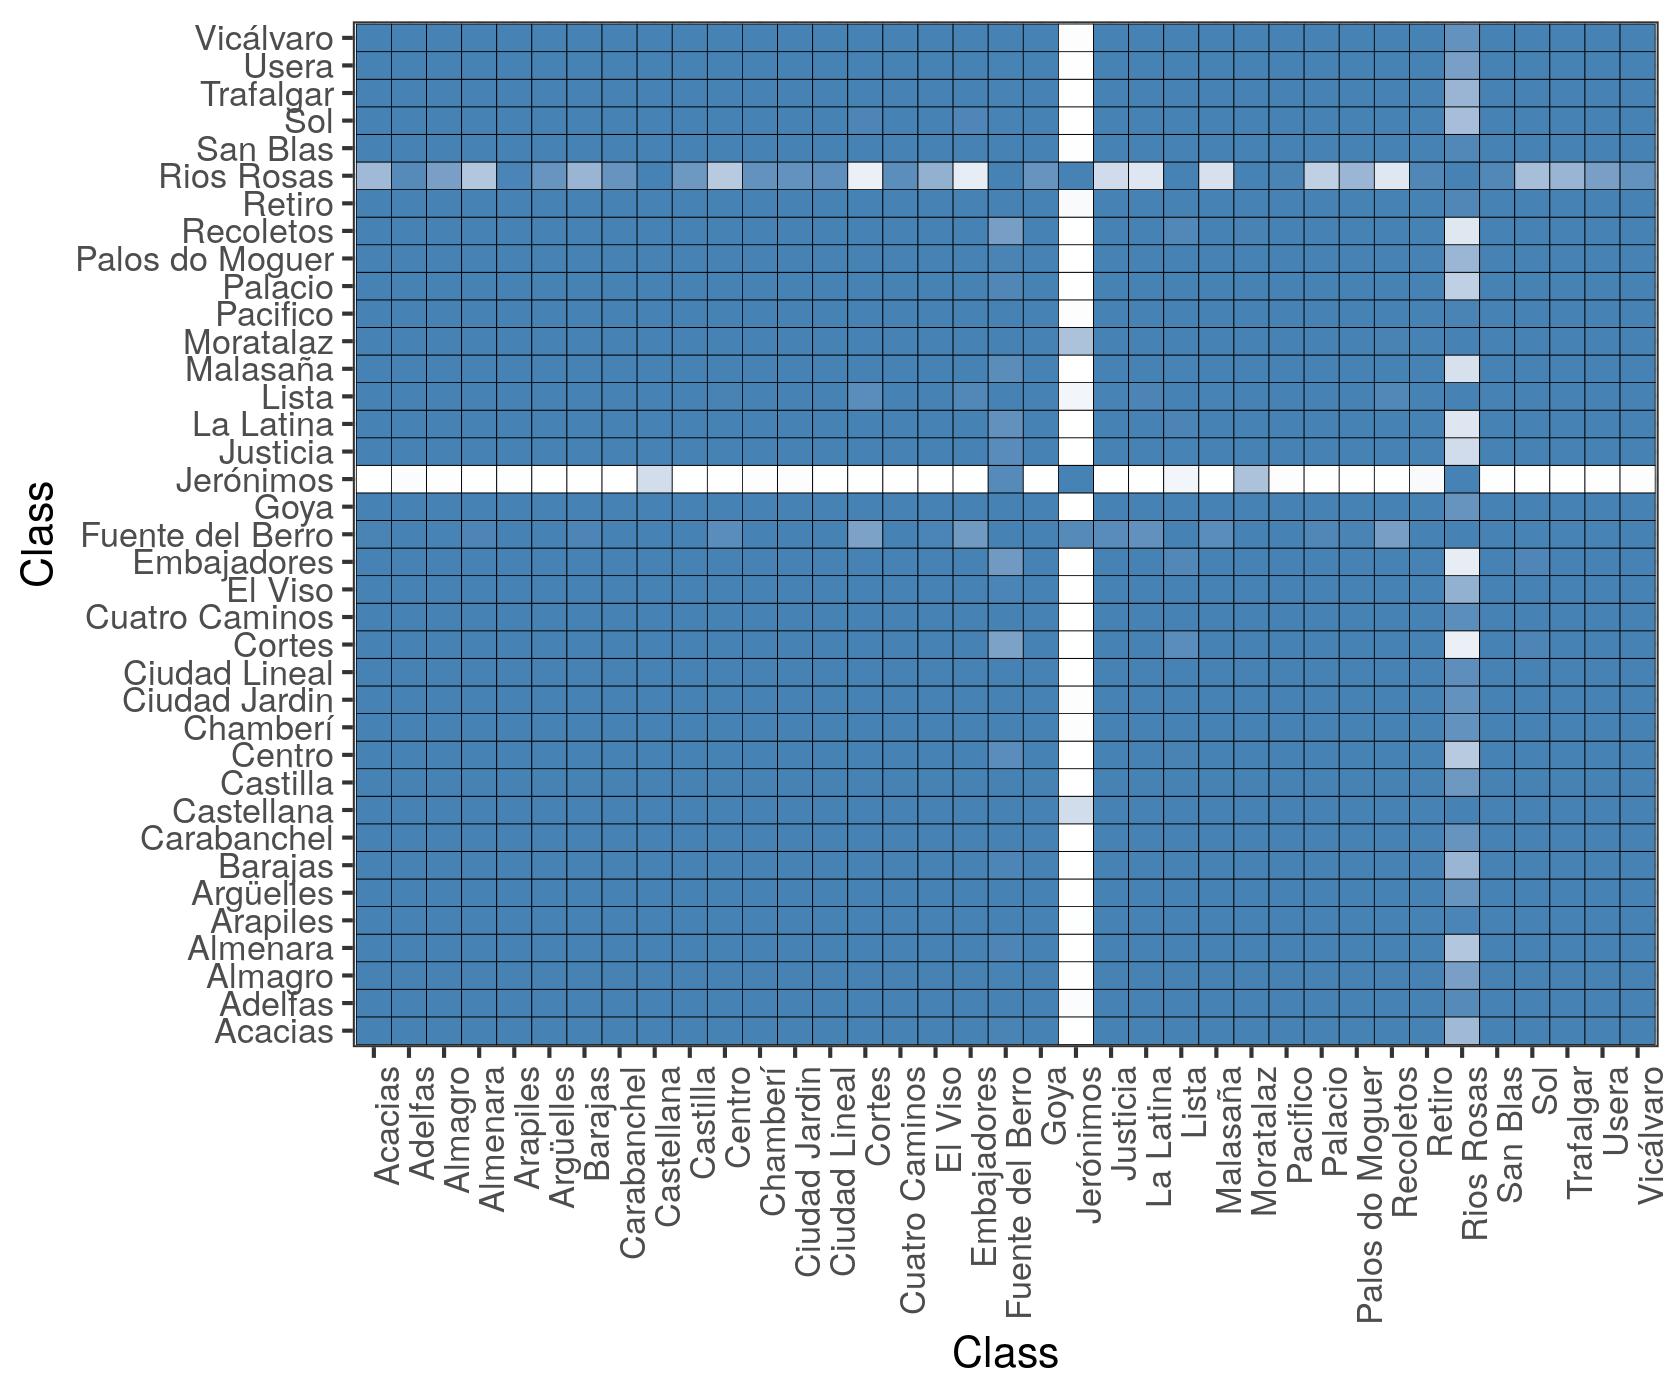

In [18]:
tky<-TukeyHSD(aov( formula=Square.Meters~Neighbourhood, data=df_madrid_no_na ))
tky.result<-data.frame(tky$Neighbourhood)
cn <-sort(unique(df_madrid_no_na$Neighbourhood))
resm <- matrix(NA, length(cn),length(cn))
rownames(resm) <- cn
colnames(resm) <- cn
resm[lower.tri(resm) ] <- round(tky.result$p.adj,4)
resm[upper.tri(resm) ] <- t(resm)[upper.tri(resm)] 
diag(resm) <- 1

library(ggplot2)
library(reshape2)
dfResm <- melt(resm)

options(repr.plot.height=5,repr.plot.width=6,repr.plot.res = 280)
ggplot(dfResm, aes(x=Var1, y=Var2, fill=value))+
  geom_tile(colour = "black")+
  scale_fill_gradient(low = "white",high = "steelblue")+
  ylab("Class")+xlab("Class")+theme_bw()+
  theme(axis.text.x = element_text(angle = 90, hjust = 1),legend.position="none")

<font color = blue>
    Como ya habiamos visto en el boxplot, Jerónimos es el barrio que está muy diferenciado del resto. El muy poco probable que se parezca a cualquiera de los otros barrios -- Hemos comprobado estadísticamente lo que ya habíamos intuido en el boxplot de forma visual
</font>

Usando como variable de distancia: 1-resm
Dibuja un dendrograma de los diferentes barrios.


In [19]:
df.dist <- as.dist(1 - resm)

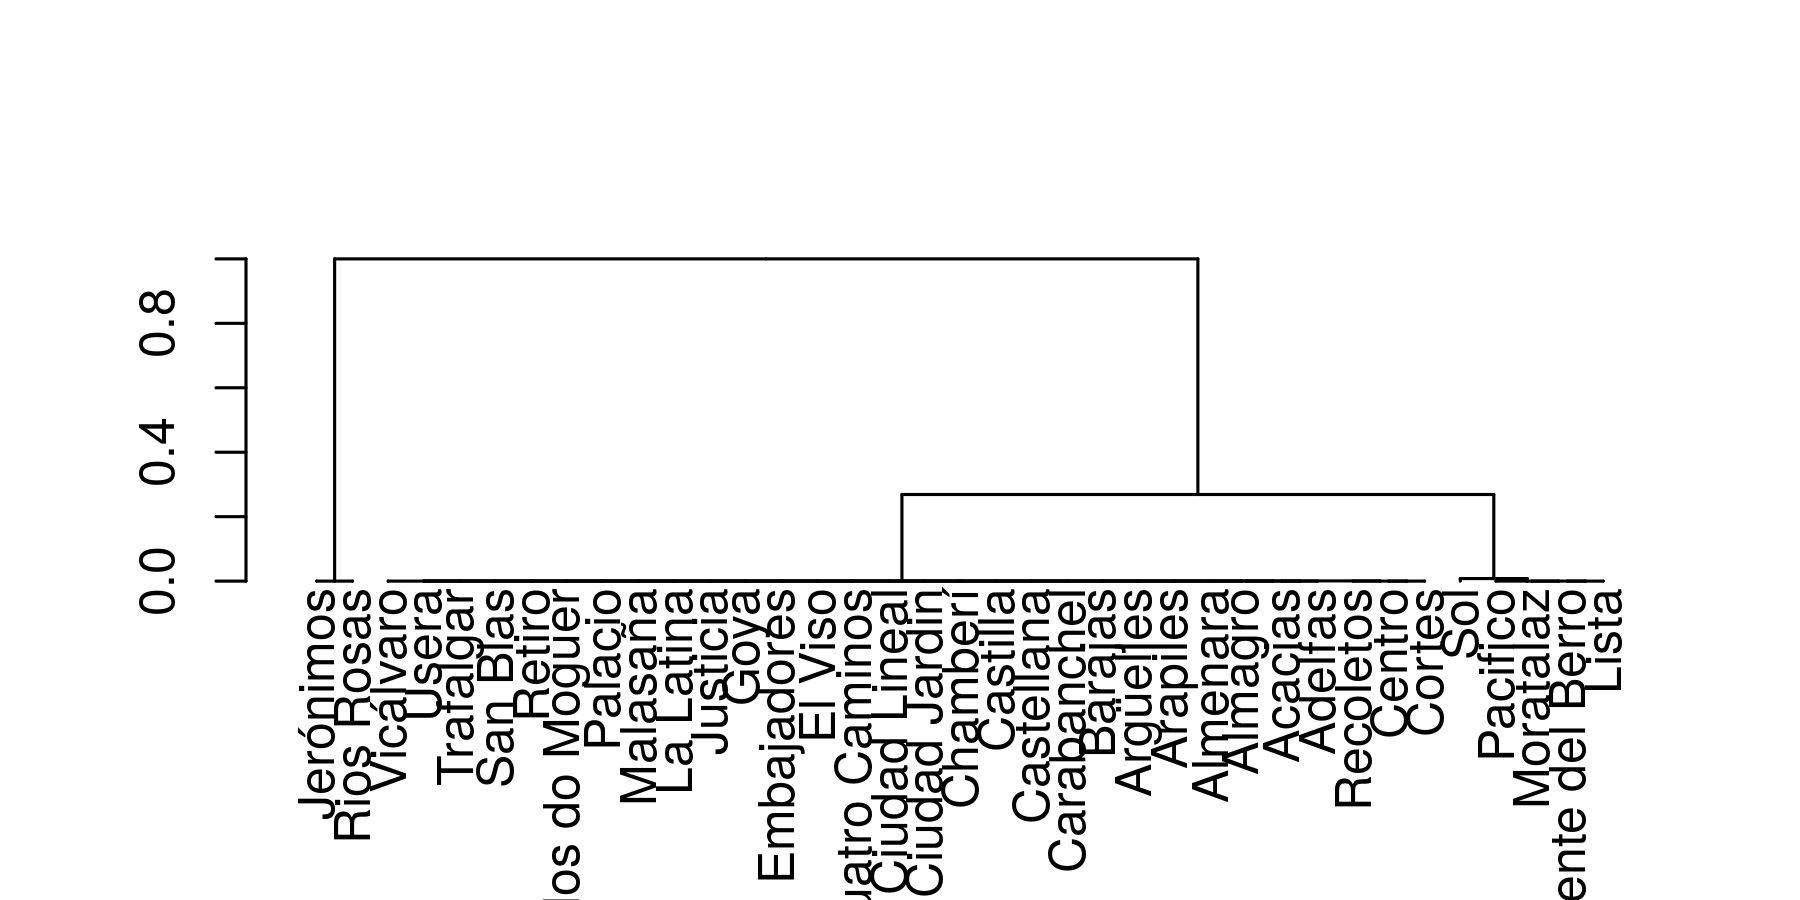

In [20]:
df.tree <- hclust(df.dist, method="complete")
df.dend <- as.dendrogram(df.tree)

options(repr.plot.height=3,repr.plot.width=6,repr.plot.res = 300)
plot(df.dend)


Estableciendo un punto de corte en 0.9, ¿cuantos clusters aparecen?

<font color = blue>
Ponemos el corte en h=0.2 y obtenemos 3 clusters
</font>

In [21]:
cutoff = 0.2


---------------------
Welcome to dendextend version 1.13.4
Type citation('dendextend') for how to cite the package.

Type browseVignettes(package = 'dendextend') for the package vignette.
The github page is: https://github.com/talgalili/dendextend/

Suggestions and bug-reports can be submitted at: https://github.com/talgalili/dendextend/issues
Or contact: <tal.galili@gmail.com>

	To suppress this message use:  suppressPackageStartupMessages(library(dendextend))
---------------------



Attaching package: ‘dendextend’


The following object is masked from ‘package:stats’:

    cutree




integer(0)

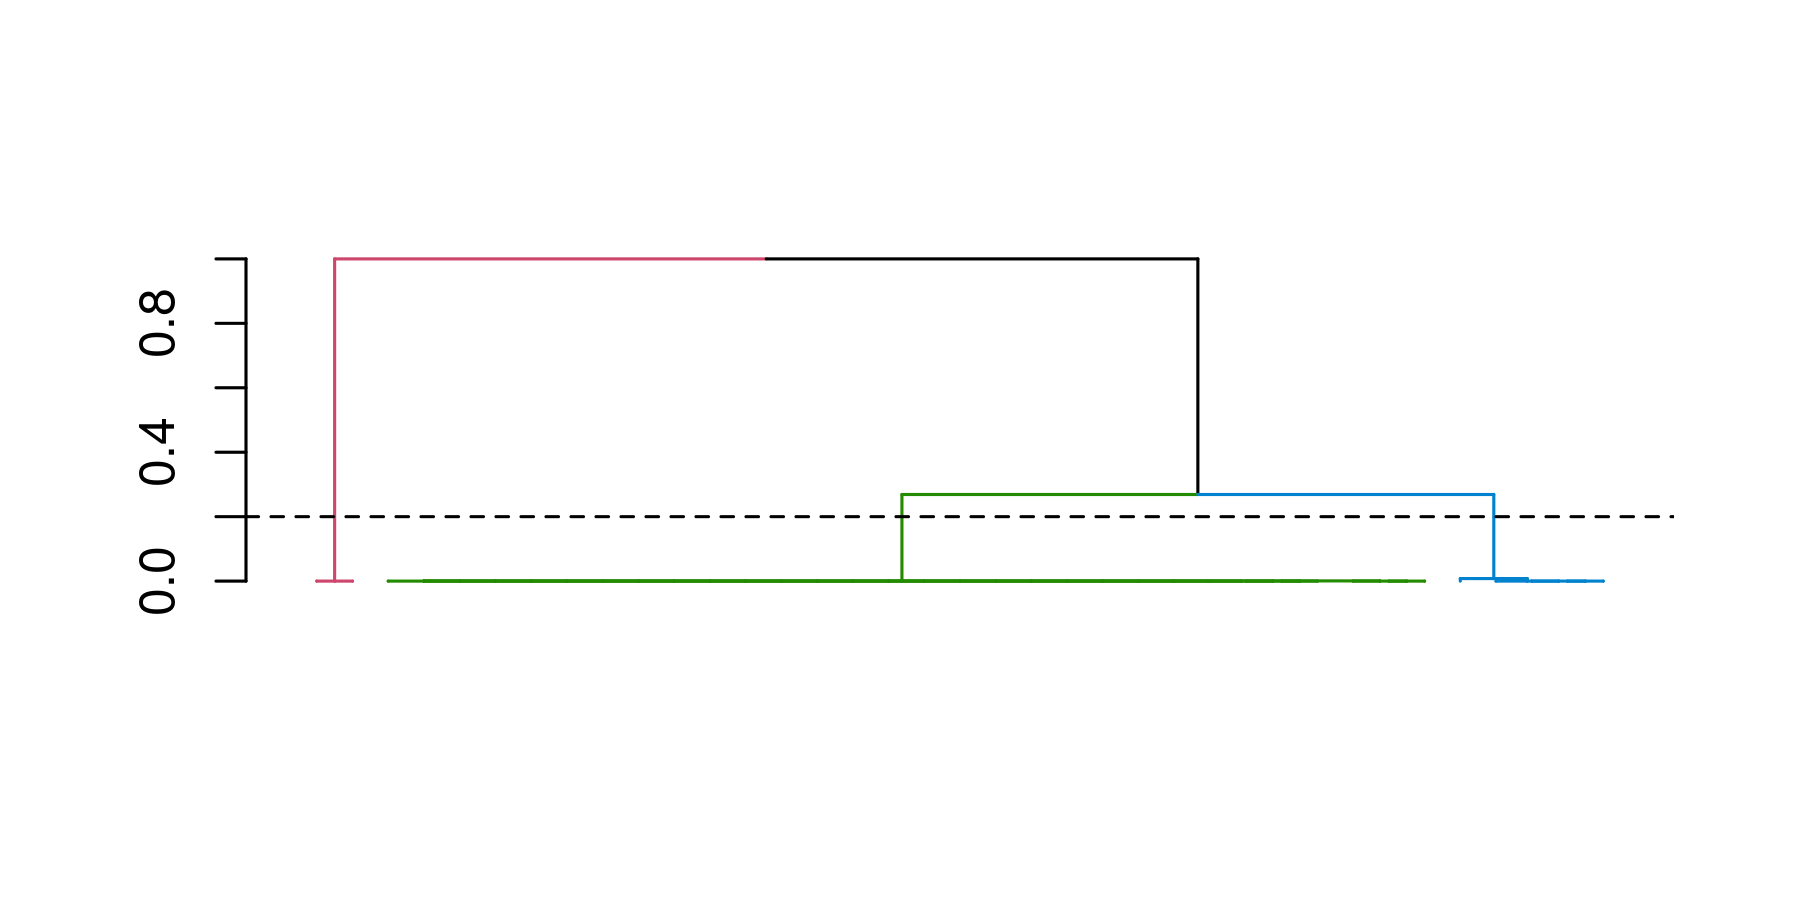

In [22]:
library(dendextend)

clusters <- cutree_1h.dendrogram(df.dend,h=cutoff)
plot(color_branches(df.dend, h = cutoff),leaflab="none") +
abline(h=cutoff,col="black",lwd=1, lty=2)

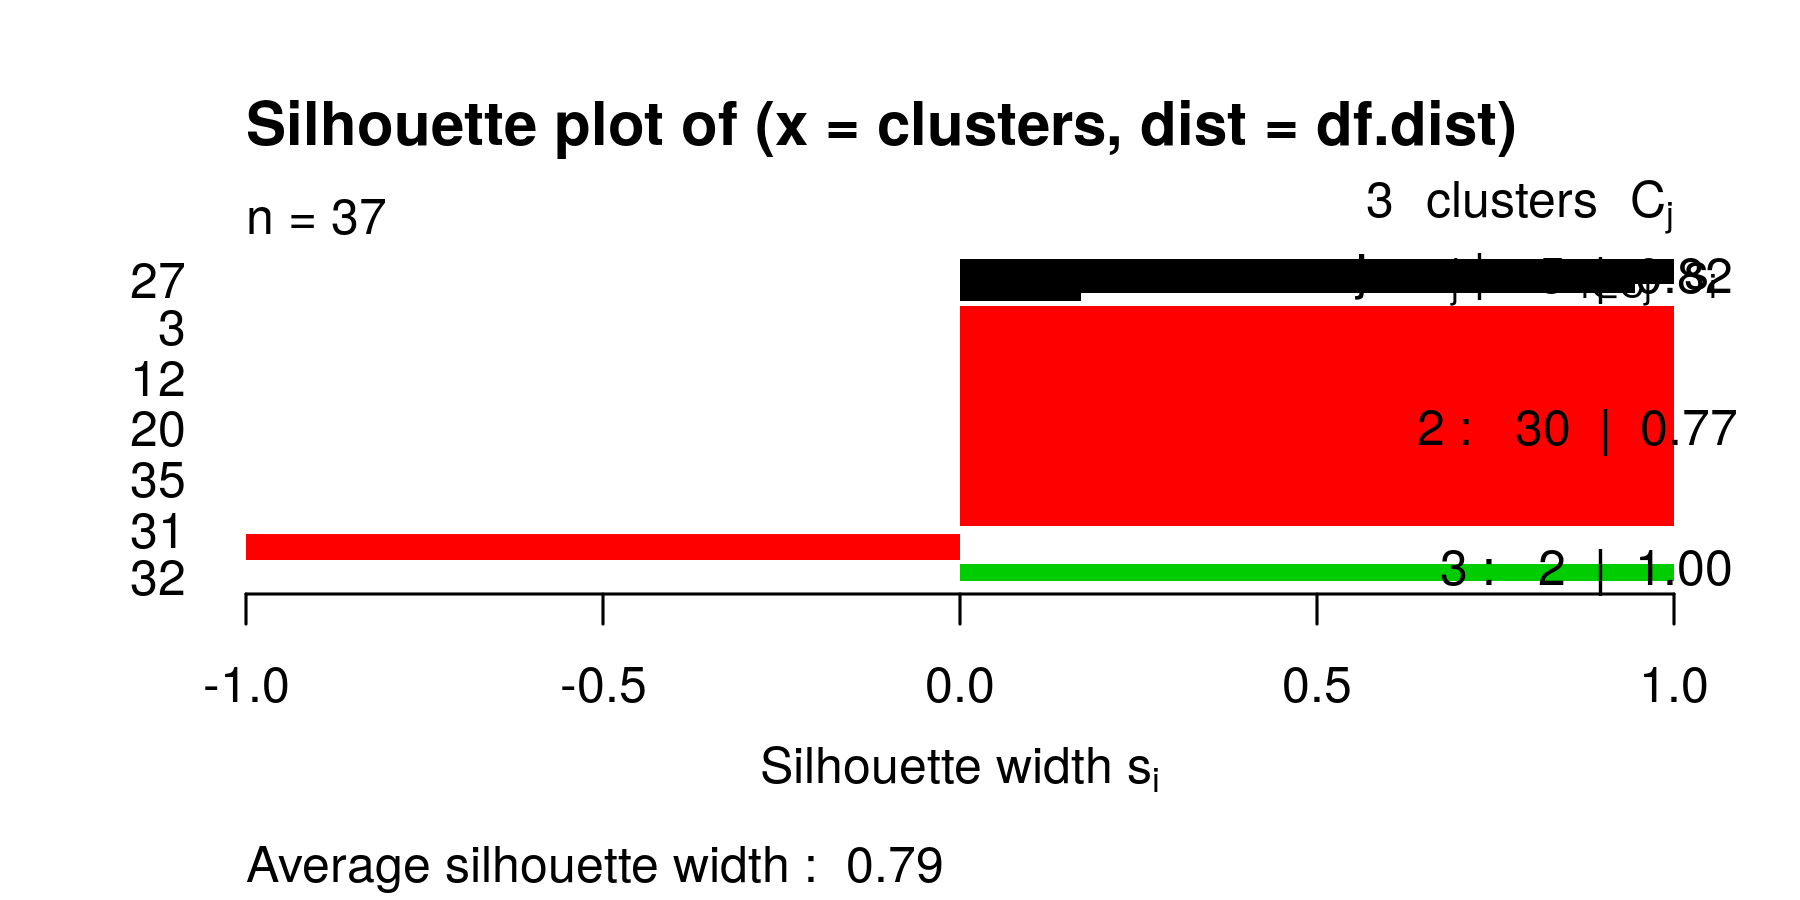

In [23]:
library(cluster)
ss<-silhouette(clusters, df.dist)
plot(ss,col=1:max(clusters),border=NA)

<font color = 'blue'>
Vemos que los 3 clusters que tenemos se diferencian bastante bien
</font>

Vamos a crear una nueva columna en el dataframe df_madrid con un nuevo identificador marcado por los clusters obtenidos. Esta columna la llamaremos neighb_id

In [24]:
df_clusters <- as.data.frame(clusters)
df_clusters['barrio'] <- names(clusters)

rownames(df_clusters)<- NULL
colnames(df_clusters) <- c('neighb_id', 'Neighbourhood')


In [25]:
df_madrid_no_na <- merge(df_madrid_no_na, df_clusters, by = 'Neighbourhood')
#head(df_madrid_no_na)

In [26]:
df_madrid_no_na$neighb_id <- factor(df_madrid_no_na$neighb_id)

Vamos a crear dos grupos, uno test y otro train.

Tratamos de predecir los metros cuadrados en función del resto de columnas del dataframe.

In [27]:
set.seed(1234)
idx<-sample(1:nrow(df_madrid_no_na),round(nrow(df_madrid_no_na)*0.8))
df_madrid_no_na.train<-df_madrid_no_na[idx,]
df_madrid_no_na.test<-df_madrid_no_na[-idx,]

In [28]:
summary(df_madrid_no_na.train)

     Neighbourhood  Accommodates      Bathrooms        Bedrooms    
 Sol        :24    Min.   : 2.000   Min.   :1.000   Min.   :0.000  
 Malasaña   :20    1st Qu.: 3.000   1st Qu.:1.000   1st Qu.:1.000  
 Embajadores:17    Median : 4.000   Median :1.000   Median :1.000  
 La Latina  :17    Mean   : 4.439   Mean   :1.284   Mean   :1.568  
 Cortes     : 6    3rd Qu.: 5.250   3rd Qu.:1.125   3rd Qu.:2.000  
 Justicia   : 5    Max.   :16.000   Max.   :5.000   Max.   :5.000  
 (Other)    :43                                                    
      Beds            Price       Guests.Included  Extra.People 
 Min.   : 1.000   Min.   : 30.0   Min.   :1.000   Min.   : 0.0  
 1st Qu.: 1.000   1st Qu.: 60.0   1st Qu.:1.000   1st Qu.: 0.0  
 Median : 2.000   Median : 75.0   Median :2.000   Median :10.0  
 Mean   : 2.644   Mean   : 92.5   Mean   :2.114   Mean   :10.3  
 3rd Qu.: 3.000   3rd Qu.: 98.5   3rd Qu.:2.000   3rd Qu.:15.0  
 Max.   :13.000   Max.   :500.0   Max.   :8.000   Max.   :50.0  
 

In [29]:
summary(df_madrid_no_na.test)

     Neighbourhood  Accommodates      Bathrooms        Bedrooms    
 Malasaña   : 4    Min.   : 2.000   Min.   :1.000   Min.   :0.000  
 Sol        : 4    1st Qu.: 4.000   1st Qu.:1.000   1st Qu.:1.000  
 Cortes     : 3    Median : 4.000   Median :1.000   Median :1.000  
 La Latina  : 3    Mean   : 4.697   Mean   :1.303   Mean   :1.606  
 Embajadores: 2    3rd Qu.: 6.000   3rd Qu.:1.000   3rd Qu.:2.000  
 Justicia   : 2    Max.   :10.000   Max.   :3.000   Max.   :4.000  
 (Other)    :15                                                    
      Beds           Price        Guests.Included  Extra.People
 Min.   :1.000   Min.   : 32.00   Min.   :1.000   Min.   : 0   
 1st Qu.:2.000   1st Qu.: 56.00   1st Qu.:2.000   1st Qu.: 5   
 Median :3.000   Median : 68.00   Median :2.000   Median :10   
 Mean   :2.818   Mean   : 96.52   Mean   :2.394   Mean   :11   
 3rd Qu.:3.000   3rd Qu.:100.00   3rd Qu.:2.000   3rd Qu.:15   
 Max.   :8.000   Max.   :500.00   Max.   :8.000   Max.   :30   
        

In [30]:
model<-lm(Square.Meters~.-Neighbourhood,data=df_madrid_no_na.train) #creamos el modelo
summary(model)


Call:
lm(formula = Square.Meters ~ . - Neighbourhood, data = df_madrid_no_na.train)

Residuals:
   Min     1Q Median     3Q    Max 
-90.60 -10.84  -1.01  10.92 124.02 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)          -5.031e+03  6.158e+03  -0.817  0.41555    
Accommodates          3.106e+00  2.547e+00   1.220  0.22495    
Bathrooms             1.795e+01  6.280e+00   2.858  0.00503 ** 
Bedrooms              1.007e+01  3.674e+00   2.740  0.00708 ** 
Beds                  4.200e+00  2.522e+00   1.665  0.09853 .  
Price                 6.682e-02  4.062e-02   1.645  0.10259    
Guests.Included      -9.333e-01  2.344e+00  -0.398  0.69123    
Extra.People          2.269e-01  2.459e-01   0.923  0.35795    
Review.Scores.Rating  2.734e-01  2.538e-01   1.077  0.28359    
Latitude              1.269e+02  1.481e+02   0.857  0.39311    
Longitude             3.316e+01  1.101e+02   0.301  0.76374    
neighb_id2           -5.174e+00  5.517e+00  -0.9

In [31]:
library(MASS)
m <- stepAIC(model,trace=FALSE)
summary(m)


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select





Call:
lm(formula = Square.Meters ~ Bathrooms + Bedrooms + Beds + Price + 
    neighb_id, data = df_madrid_no_na.train)

Residuals:
    Min      1Q  Median      3Q     Max 
-92.645 -10.909  -0.662  11.698 126.121 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  4.44268    7.31581   0.607 0.544772    
Bathrooms   20.88602    5.43361   3.844 0.000192 ***
Bedrooms    11.36131    3.38996   3.351 0.001064 ** 
Beds         6.46462    1.80437   3.583 0.000485 ***
Price        0.06303    0.03900   1.616 0.108570    
neighb_id2  -5.25376    5.25555  -1.000 0.319407    
neighb_id3  81.18381   17.89803   4.536 1.33e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 23.87 on 125 degrees of freedom
Multiple R-squared:  0.764,	Adjusted R-squared:  0.7527 
F-statistic: 67.45 on 6 and 125 DF,  p-value: < 2.2e-16


In [32]:
df_madrid_no_na.train$meters_est<-predict(m,df_madrid_no_na.train)

In [33]:
head(df_madrid_no_na.train)

,Neighbourhood,Accommodates,Bathrooms,Bedrooms,Beds,Price,Guests.Included,Extra.People,Review.Scores.Rating,Latitude,Longitude,Square.Meters,neighb_id,meters_est
,<fct>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>
28,Cortes,4,1,1,4,59,2,10,84,40.41365,-3.700718,39.01926,2,61.01338
80,La Latina,2,1,1,1,75,1,0,98,40.40862,-3.707649,40.04119,2,42.62797
150,Sol,4,1,0,2,60,2,0,80,40.41911,-3.706793,36.97539,1,42.03962
101,Malasaña,2,1,1,1,90,1,0,98,40.42918,-3.708982,65.03210,2,43.57339
111,Malasaña,4,1,1,1,55,1,10,91,40.42571,-3.703933,41.99216,2,41.36741
137,Sol,4,1,1,2,95,2,15,90,40.41552,-3.706460,65.03210,1,55.60691


In [34]:
myrsquared<-function(Y,est_Y){
    Rsq <- 1-(sum((Y-est_Y)^2))/(sum((Y-mean(Y))^2))
    return(Rsq)
}

[1] 23.22899

[1] 0.7640177

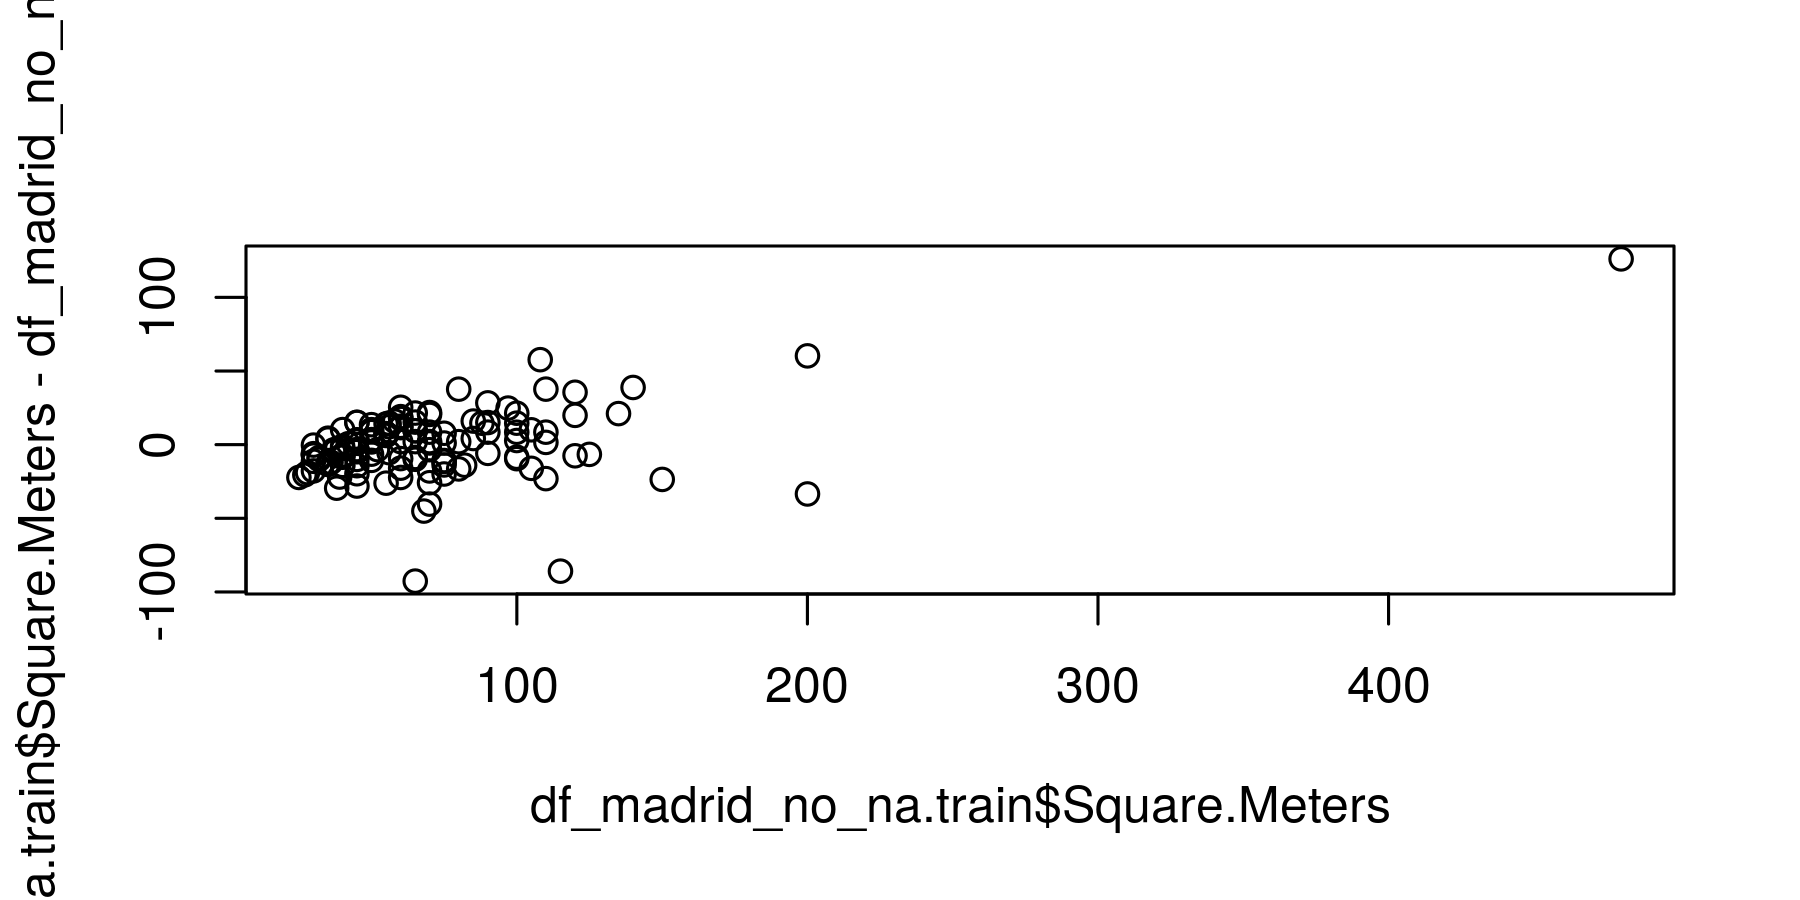

In [35]:
plot(df_madrid_no_na.train$Square.Meters,(df_madrid_no_na.train$Square.Meters-df_madrid_no_na.train$meters_est))
sqrt(mean((df_madrid_no_na.train$Square.Meters-df_madrid_no_na.train$meters_est)^2))
myrsquared(df_madrid_no_na.train$Square.Meters,df_madrid_no_na.train$meters_est)

Mirad el histograma de los residuos sobre el conjunto de test para evaluar la calidad de vuestro modelo

[1] 28.77358

[1] 0.4703838

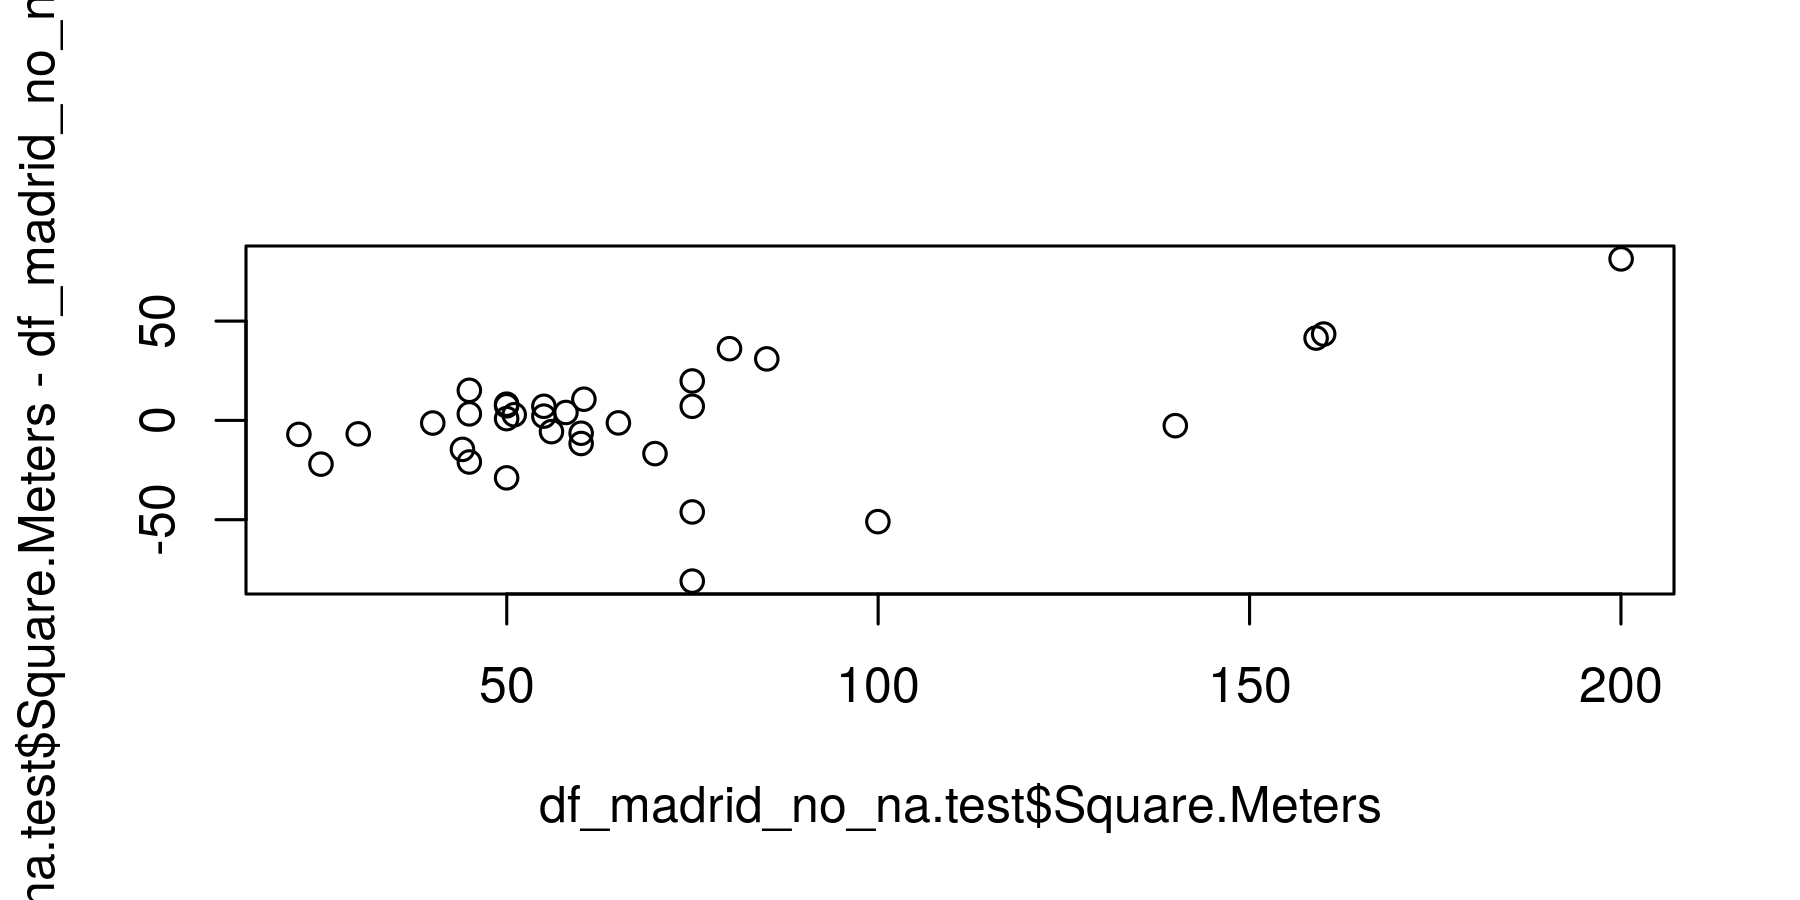

In [36]:
df_madrid_no_na.test$meters_est<-predict(m,df_madrid_no_na.test)

plot(df_madrid_no_na.test$Square.Meters,(df_madrid_no_na.test$Square.Meters-df_madrid_no_na.test$meters_est))
sqrt(mean((df_madrid_no_na.test$Square.Meters-df_madrid_no_na.test$meters_est)^2))
myrsquared(df_madrid_no_na.test$Square.Meters,df_madrid_no_na.test$meters_est)

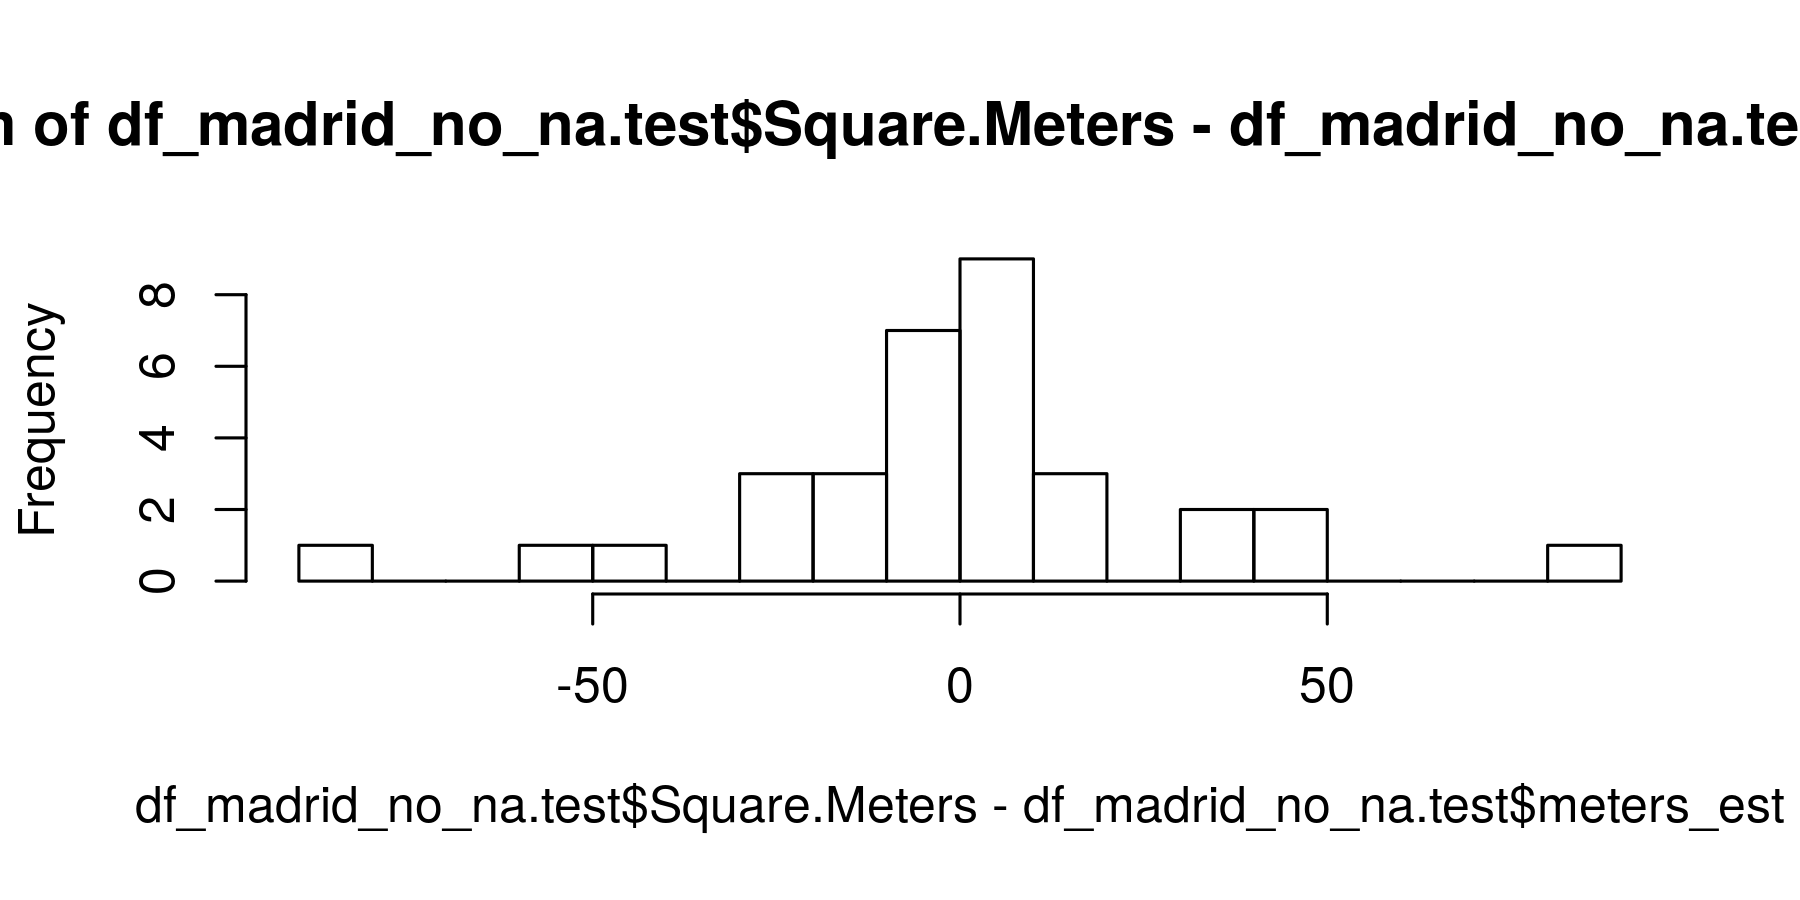

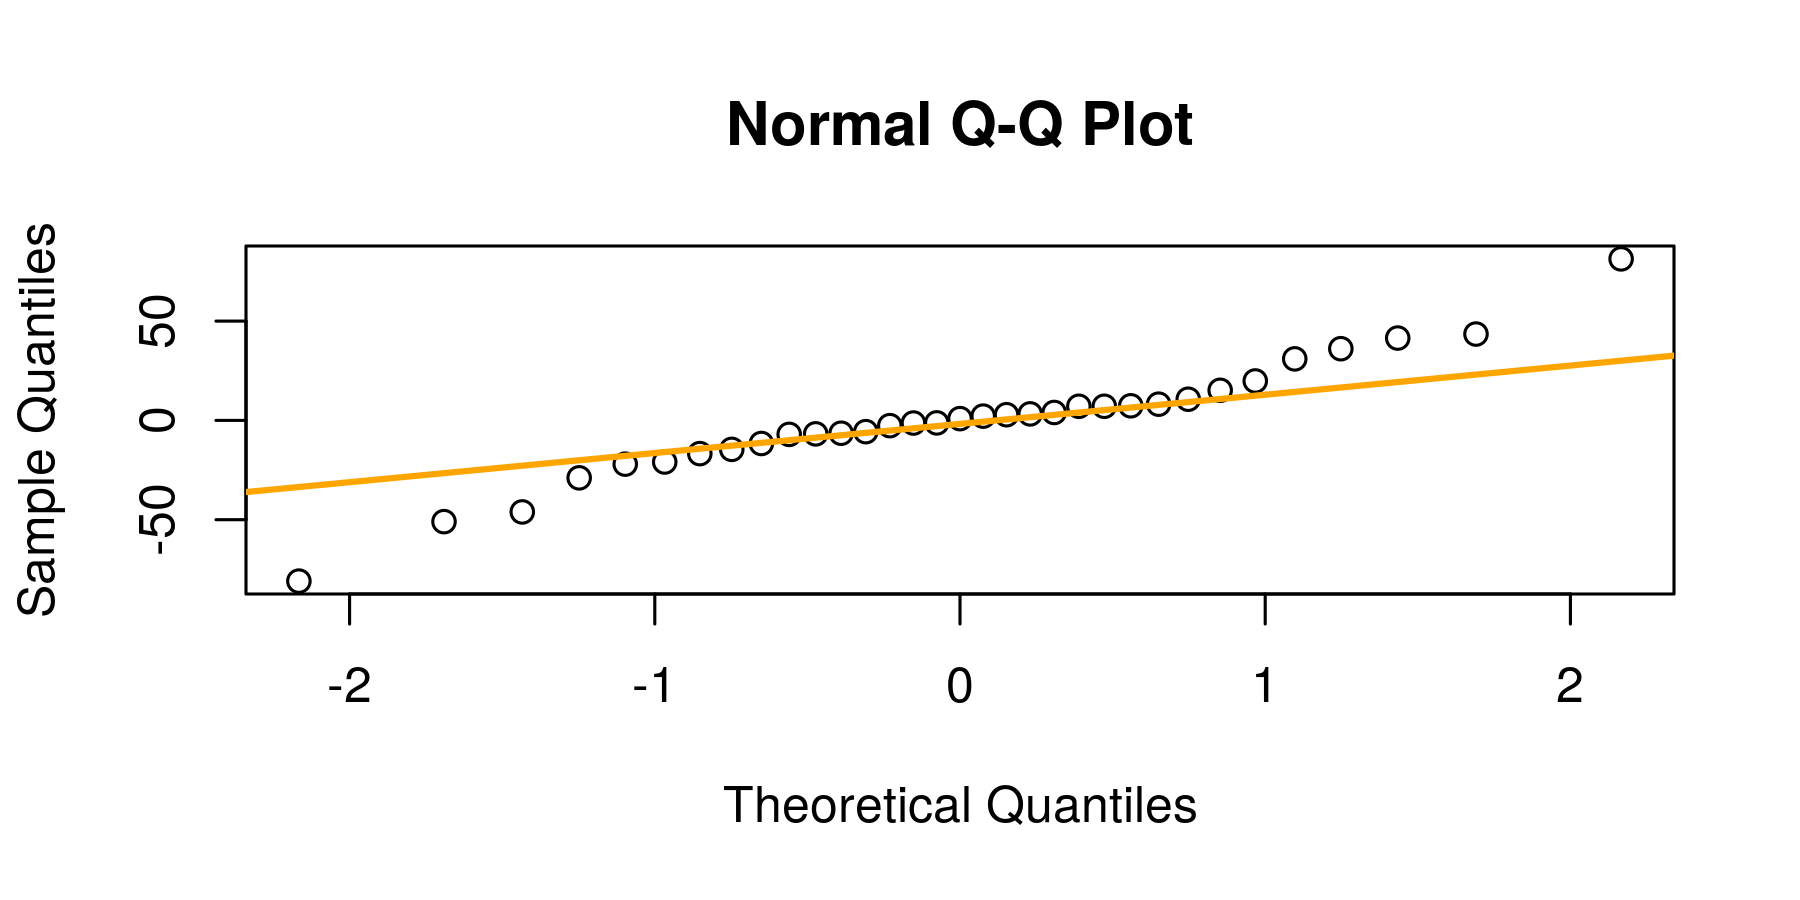

In [37]:
hist(df_madrid_no_na.test$Square.Meters-df_madrid_no_na.test$meters_est,20)
qqnorm(df_madrid_no_na.test$Square.Meters-df_madrid_no_na.test$meters_est)
qqline(df_madrid_no_na.test$Square.Meters-df_madrid_no_na.test$meters_est, col = 'orange', lwd =2)

<font color = blue>
    Parece que el modelo tiene algo de overfitting. Podriamos probar a quitar algunas variables de la formula. <br> (No lo he hecho porque iba mal de tiempo)
</font>     

Si tuvieramos un anuncio de un apartamento para 6 personas (Accommodates) con un precio de 80€/noche y 3 habitaciones en el barrio de Sol.
¿Cuantos metros cuadrados tendría?
¿Como varía sus metros cuadrados con cada habitación adicional?

In [38]:
bathrooms = 2
bedrooms = 3
beds = 3
precio = 80
barrio = 'Sol' #--> convert to id

#lm(formula = Square.Meters ~ Bathrooms + Bedrooms + Beds + Price + neighb_id, data = df_madrid_no_na.train)
id <- df_clusters$neighb_id[df_clusters$Neighbourhood == barrio]
prueba <- data.frame(
                "Bathrooms" = bathrooms,
                "Bedrooms" = bedrooms,
                "Beds" = beds,
                "Price" = precio, 
                "neighb_id" = factor(id))

estimation<-predict(m,prueba)

paste("La estimación de metros cuadrados que tendría un piso con estas características es de:", round(estimation,2), "m2")

[1] "La estimación de metros cuadrados que tendría un piso con estas características es de: 104.73 m2"

In [39]:
summary(m)


Call:
lm(formula = Square.Meters ~ Bathrooms + Bedrooms + Beds + Price + 
    neighb_id, data = df_madrid_no_na.train)

Residuals:
    Min      1Q  Median      3Q     Max 
-92.645 -10.909  -0.662  11.698 126.121 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  4.44268    7.31581   0.607 0.544772    
Bathrooms   20.88602    5.43361   3.844 0.000192 ***
Bedrooms    11.36131    3.38996   3.351 0.001064 ** 
Beds         6.46462    1.80437   3.583 0.000485 ***
Price        0.06303    0.03900   1.616 0.108570    
neighb_id2  -5.25376    5.25555  -1.000 0.319407    
neighb_id3  81.18381   17.89803   4.536 1.33e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 23.87 on 125 degrees of freedom
Multiple R-squared:  0.764,	Adjusted R-squared:  0.7527 
F-statistic: 67.45 on 6 and 125 DF,  p-value: < 2.2e-16


<font color = blue>
Con el summary del modelo podemos ver que el coeficiente de la varible 'bedrooms' es 11.36<br> Esto significa que conforme por cada habitación que añadimos, el resultado aumenta 11.36 metros cuadrados.
</font>

In [40]:
bathrooms = 2
bedrooms = 4
beds = 3
precio = 80
barrio = 'Sol' #--> convert to id

#lm(formula = Square.Meters ~ Bathrooms + Bedrooms + Beds + Price + neighb_id, data = df_madrid_no_na.train)
id <- df_clusters$neighb_id[df_clusters$Neighbourhood == barrio]
prueba <- data.frame(
                "Bathrooms" = bathrooms,
                "Bedrooms" = bedrooms,
                "Beds" = beds,
                "Price" = precio, 
                "neighb_id" = factor(id))

estimation2<-predict(m,prueba)

paste("La estimación de metros cuadrados que tendría un piso con estas características es de:", round(estimation2,2), "m2")
paste("Por una hab más, los metros cuadrados han aumentado un valor de:", round(estimation2-estimation,5))

[1] "La estimación de metros cuadrados que tendría un piso con estas características es de: 116.1 m2"

[1] "Por una hab más, los metros cuadrados han aumentado un valor de: 11.36131"

Rellenar los Square.Meters con valor NA con el estimado con el modelo anterior.

In [41]:
df_madrid <- merge(df_madrid, df_clusters, by = 'Neighbourhood')
df_madrid$neighb_id <- factor(df_madrid$neighb_id)

In [42]:
#y<-sapply(x,function(xi) rnorm(1,mean=xi*5+3,sd=10))
for (i in 1:nrow(df_madrid)) {
     if(is.na(df_madrid[i, "Square.Meters"])){
        estimation <- predict(m,df_madrid[i,])
        df_madrid[i, "Square.Meters"] <- estimation
     }
}


In [43]:
df_madrid[is.na(df_madrid$Square.Meters),]

,Neighbourhood,Accommodates,Bathrooms,Bedrooms,Beds,Price,Guests.Included,Extra.People,Review.Scores.Rating,Latitude,Longitude,Square.Meters,neighb_id
,<fct>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<fct>
313,Argüelles,5,NA,1,1,65,2,10,78,40.43033,-3.717796,NA,2
398,Carabanchel,2,NA,3,NA,79,1,0,NA,40.38625,-3.741470,NA,2
431,Castellana,4,2,2,2,NA,1,0,NA,40.43447,-3.682262,NA,2
503,Centro,4,1,NA,2,82,1,5,NA,40.42639,-3.712011,NA,2
569,Ciudad Lineal,6,NA,4,NA,300,1,0,NA,40.46927,-3.664675,NA,2
1309,Embajadores,3,NA,1,2,55,2,10,86,40.40881,-3.700918,NA,2
1411,Embajadores,2,NA,1,NA,34,1,6,88,40.40809,-3.700322,NA,2
1493,Embajadores,6,NA,2,5,120,4,10,87,40.41175,-3.699313,NA,2
1548,Embajadores,2,1,NA,1,38,1,0,91,40.40922,-3.701001,NA,2


<font color = blue>
Podemos ver que aún tenemos 24 filas cuyo valor es NA. Esto es porque las variables que está utilizando para predecir tienen valor NA por lo que no puede aplicar la fórmula. <br> De todas formas vemos que el número de NAs ha reducido a algo asequible (de 4727 a 24!)
</font>

Usar PCA para encontrar el apartamento más cercano a uno dado.

Este algoritmo nos ayudaría a dado un apartamento que el algoritmo nos devolvería los 5 apartamentos más similares.


Crearemos una función tal que le pasemos un apartamento con los siguientes datos:
* Accommodates	
* Bathrooms	
* Bedrooms	
* Beds	
* Price	
* Guests.Included	
* Extra.People	
* Review.Scores.Rating	
* Latitude	
* Longitude	
* Square.Meters

y nos devuelva los 5 más similares de:

In [44]:
df_madrid <-df_madrid[complete.cases(df_madrid), ]

toDelete <- c('Neighbourhood', 'neighb_id',"Guests.Included")
df_madrid <- df_madrid[ , !(names(df_madrid) %in% toDelete)]


In [45]:
prmydata<-prcomp(df_madrid,center = FALSE, scale. = FALSE)

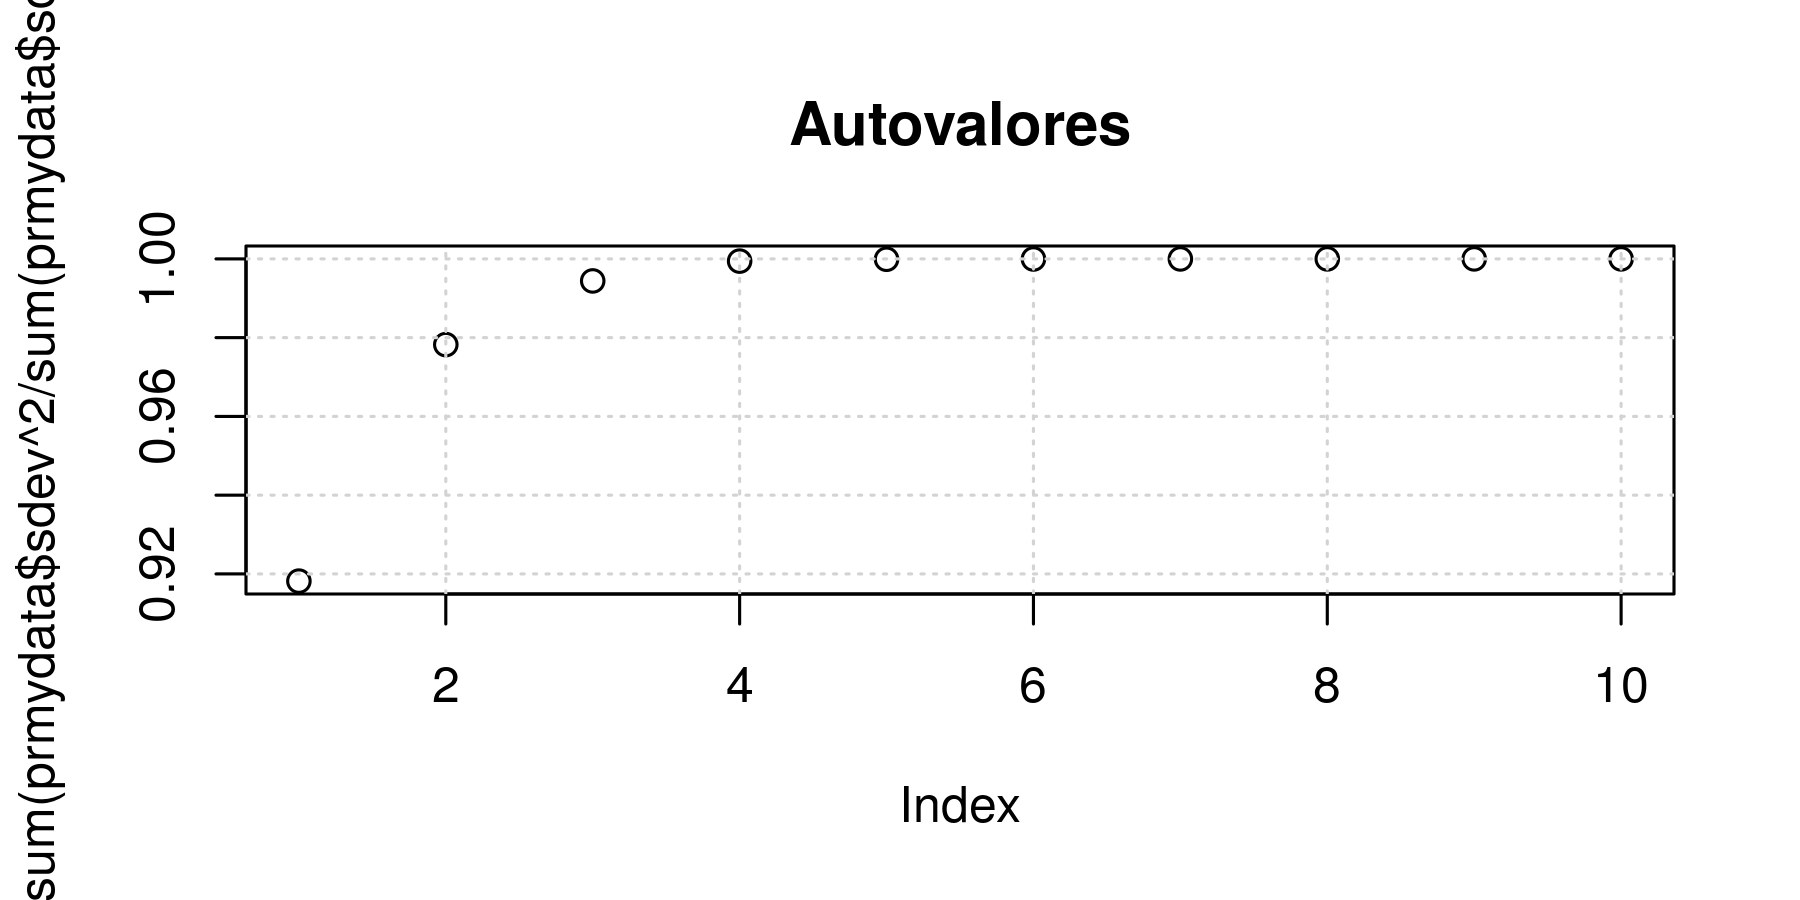

In [46]:
plot(cumsum(prmydata$sdev^2/sum(prmydata$sdev^2)),main="Autovalores")
grid()

<font color = blue>
Vemos que con dos autovalores ya tenemos casi el 98% de la información comprimida. Por lo que quedandonos con los dos primeros casi no tenemos pérdida de informacion
</font>

In [47]:
number_of_pca_components<-2

<font color = blue>
    Introducir los datos para el apartamento nuevo que queremos buscar los más parecidos:
</font>

In [95]:
accommodates<- 4
bathrooms <- 2
bedrooms<- 3
beds <- 3
price <- 100
extra.People  <- 0
review.Scores.Rating <- 96
latitude<- 40.4
longitude <- -3.71
square.Meters <- 85

apartamento <- data.frame("Accomodates" = accommodates,
                         "Bathrooms" = bathrooms,
                         "Bedrooms" = bedrooms,
                         "Beds" = beds,
                         "Price" = price,
                         "Extra.People" = extra.People,
                         "Review.Scores.Rating" = review.Scores.Rating,
                         "Latitude" = latitude,
                         "Longitude" = longitude,
                         "Square.Meters" = square.Meters)

In [96]:
apartamento_transformed <- matrix(unlist(apartamento),nrow=1) %*% prmydata$rotation

In [97]:
apartamento_transformed<-matrix(apartamento_transformed[1:number_of_pca_components],nrow=1)

In [98]:
Apc<-prmydata$x[,1:number_of_pca_components]
dist<-rowSums((apartamento_transformed[rep(1, times = nrow(prmydata$x)), ]-Apc)^2)

In [99]:
similar <- which.min(dist)
min(dist)
similar

[1] 0.3145677

3765 
3212

In [100]:
df_madrid[similar,]

,Accommodates,Bathrooms,Bedrooms,Beds,Price,Extra.People,Review.Scores.Rating,Latitude,Longitude,Square.Meters
,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
3765,5,2,2,2,100,15,95,40.42156,-3.709848,82.91562


<font color = blue>
    Hasta aquí vemos como con el PCA vemos el apartamento que más se parece al que hemos introducido nosotros de forma manual. Podemos ver que los valores son realmente parecidos.
</font>

<font color = blue>
    Ahora sacamos los 5 más parecidos
</font>

In [101]:
nsimilar<-5
result <- data.frame("Accomodates" = integer(),
                         "Bathrooms" = double(),
                         "Bedrooms" = integer(),
                         "Beds" = integer(),
                         "Price" = integer(),
                         "Extra.People" = integer(),
                         "Review.Scores.Rating" = integer(),
                         "Latitude" = double(),
                         "Longitude" = double(),
                         "Square.Meters" = double()) 


Apc<-prmydata$x[,1:number_of_pca_components]

apartamento_transformed <- matrix(unlist(apartamento),nrow=1) %*% prmydata$rotation
apartamento_transformed<-matrix(apartamento_transformed[1:number_of_pca_components],nrow=1)
        
dist<-rowSums((apartamento_transformed[rep(1, times = nrow(prmydata$x)), ]-Apc)^2)
dist <- sort(dist,decreasing = F)
index <-rownames(df_madrid)[dist]
for (i in 1:nsimilar){
    result <- rbind(as.matrix(result), as.matrix(df_madrid[index[i],]))
}                           
#knn_tags<-rownames(df_madrid)[order(dist,decreasing = F) %in% c(1:knn)]
#most_common_name<-names(sort(table(knn_tags),decreasing = T))


#for (apart in most_common_name){
#    result <- rbind(as.matrix(result), as.matrix(df_madrid[apart,]))
#}
result
print("Las distancias son:")
for (i in 1:nsimilar){
    print(dist[i])
}

,Accomodates,Bathrooms,Bedrooms,Beds,Price,Extra.People,Review.Scores.Rating,Latitude,Longitude,Square.Meters
1,4,2,2,4,90,25,92,40.40435,-3.706820,95.21457
1,4,2,2,4,90,25,92,40.40435,-3.706820,95.21457
1,4,2,2,4,90,25,92,40.40435,-3.706820,95.21457
3,2,1,1,1,75,0,100,40.40460,-3.708392,42.62797
3,2,1,1,1,75,0,100,40.40460,-3.708392,42.62797


[1] "Las distancias son:"
     3765 
0.3145677 
     736 
0.373753 
     3652 
0.4366042 
      114 
0.6218024 
     2724 
0.8705251 


Bonus: ¿de todas las coordenadas PCA cual es la que mejor permite clasificar por id de barrio?

¿Por qué?